# Laboratorio 5 – RNN (LSTM) para Series de Tiempo
### Integrantes:
    - Carlos Valladares
    - Gabriel Paz


## 1) Carga y exploración de datos
Traemos la serie **IPN31152N** desde FRED con `pandas_datareader` y hacemos una gráfica exploratoria para ver tendencia/estacionalidad.

,valor
DATE,
2025-02-01,108.9906
2025-03-01,114.5922
2025-04-01,116.9527
2025-05-01,118.2192
2025-06-01,127.0128


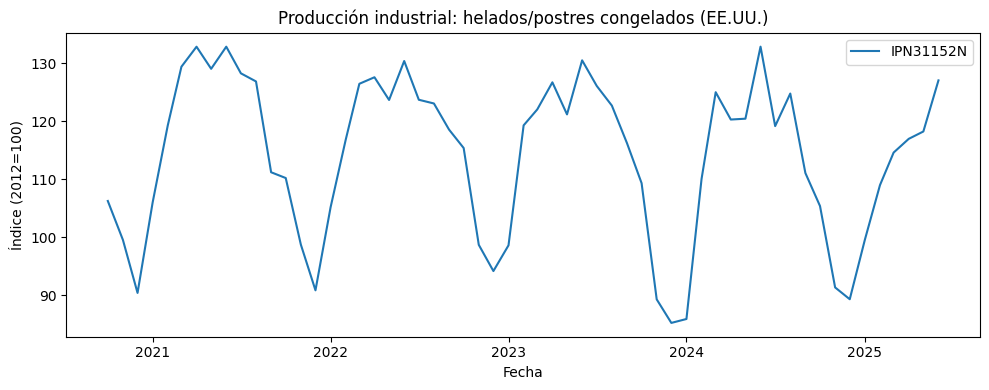

Observación rápida: estacionalidad clara (picos en meses cálidos y caídas en meses fríos).


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr

# Cargar la serie (puede tardar unos segundos si FRED responde lento)
serie = pdr.DataReader("IPN31152N", "fred").dropna()
serie = serie.rename(columns={"IPN31152N": "valor"})
display(serie.tail())

plt.figure(figsize=(10,4))
plt.plot(serie.index, serie["valor"], label="IPN31152N")
plt.title("Producción industrial: helados/postres congelados (EE.UU.)")
plt.xlabel("Fecha"); plt.ylabel("Índice (2012=100)"); plt.legend()
plt.tight_layout(); plt.show()

print("Observación rápida: estacionalidad clara (picos en meses cálidos y caídas en meses fríos).")

## 2) División de conjuntos (train/test)
Usamos los **últimos 24 meses** como **conjunto de prueba**, tal como indica la guía.

In [10]:
H_TEST = 24
train = serie.iloc[:-H_TEST].copy()
test  = serie.iloc[-H_TEST:].copy()
len(train), len(test), test.head(3), test.tail(3)

(33,
 24,
                valor
 DATE                
 2023-07-01  126.0569
 2023-08-01  122.6748
 2023-09-01  116.2177,
                valor
 DATE                
 2025-04-01  116.9527
 2025-05-01  118.2192
 2025-06-01  127.0128)

## 3) Normalización y preparación de ventanas (PyTorch)
Normalizamos con **MinMaxScaler [0,1]** y construimos ventanas deslizantes de **12 meses** (equivalente conceptual a `TimeseriesGenerator`).

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[["valor"]])
test_scaled  = scaler.transform(test[["valor"]])

def make_windows(series_scaled: np.ndarray, window: int):
    X, y = [], []
    for i in range(len(series_scaled) - window):
        X.append(series_scaled[i:i+window])
        y.append(series_scaled[i+window])
    X = np.array(X)  # [N, window, 1]
    y = np.array(y)  # [N, 1]
    return X, y

WINDOW = 12
X_train, y_train = make_windows(train_scaled, WINDOW)

X_train.shape, y_train.shape

((21, 12, 1), (21, 1))

## 4) Modelo LSTM en **PyTorch**
Definimos un LSTM sencillo con `hidden_size=64`, `num_layers=2` y `Dropout=0.2`.

In [12]:
import torch
import torch.nn as nn

# Tensores
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # [N, T, 1]
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # [N, 1]

class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden=64, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)      # [B,T,H]
        last = out[:, -1, :]       # [B,H]
        return self.fc(last)       # [B,1]

model = LSTMPredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())

50497

## 5) Entrenamiento (PyTorch)
Entrenamos ~80 épocas. Se puede ajustar según tu hardware/tiempo; con CPU suele ser rápido.

Epoch   1/80 - loss: 0.332274
Epoch  10/80 - loss: 0.123797
Epoch  20/80 - loss: 0.089477
Epoch  30/80 - loss: 0.087582
Epoch  40/80 - loss: 0.084124
Epoch  50/80 - loss: 0.080354
Epoch  60/80 - loss: 0.080194
Epoch  70/80 - loss: 0.077303
Epoch  80/80 - loss: 0.061281


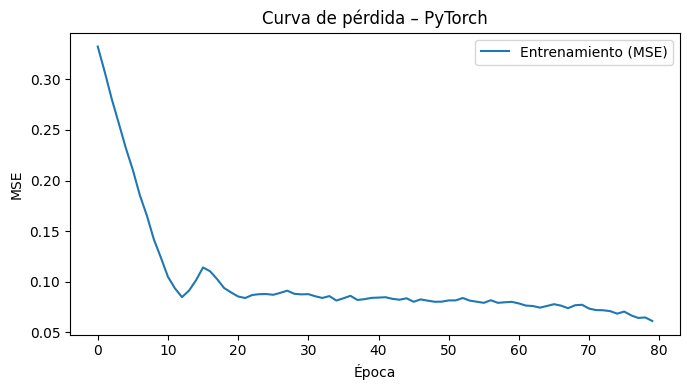

In [13]:
def batches(X, y, bs):
    for i in range(0, len(X), bs):
        yield X[i:i+bs], y[i:i+bs]

epochs = 80
batch_size = 32
loss_hist = []

model.train()
for ep in range(1, epochs+1):
    perm = torch.randperm(len(X_train_t))
    X_ep = X_train_t[perm]
    y_ep = y_train_t[perm]

    running = 0.0
    for Xb, yb in batches(X_ep, y_ep, batch_size):
        optimizer.zero_grad()
        preds = model(Xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * len(Xb)

    epoch_loss = running / len(X_train_t)
    loss_hist.append(epoch_loss)
    if ep % 10 == 0 or ep == 1:
        print(f"Epoch {ep:3d}/{epochs} - loss: {epoch_loss:.6f}")

# Curva de pérdida
plt.figure(figsize=(7,4))
plt.plot(loss_hist, label="Entrenamiento (MSE)")
plt.title("Curva de pérdida – PyTorch")
plt.xlabel("Época"); plt.ylabel("MSE"); plt.legend(); plt.tight_layout(); plt.show()

## 6) Predicción de los **próximos 24 meses** (PyTorch)
Predicción multi-paso: tomamos la **última ventana** del train y vamos **iterando** 24 pasos.

In [14]:
model.eval()
H = 24  # horizonte (test)

last_window = train_scaled[-WINDOW:].copy().reshape(1, WINDOW, 1)
cur = torch.tensor(last_window, dtype=torch.float32)

pred_scaled_list = []
with torch.no_grad():
    for _ in range(H):
        p = model(cur)                         # [1,1]
        pred_scaled_list.append(p.numpy())
        cur = torch.cat([cur[:,1:,:], p.view(1,1,1)], dim=1)

pred_scaled = np.vstack(pred_scaled_list)      # [H,1]
pred = scaler.inverse_transform(pred_scaled)   # escala original

pred[:5].ravel()

array([118.46612 , 117.48749 , 116.51793 , 115.73526 , 115.236374],
      dtype=float32)

## 7) Métricas y comparación (PyTorch)
Calculamos **RMSE** y **MAE**, y graficamos **Entrenamiento vs Real (Prueba) vs Predicción**.

RMSE: 14.401
MAE : 10.917


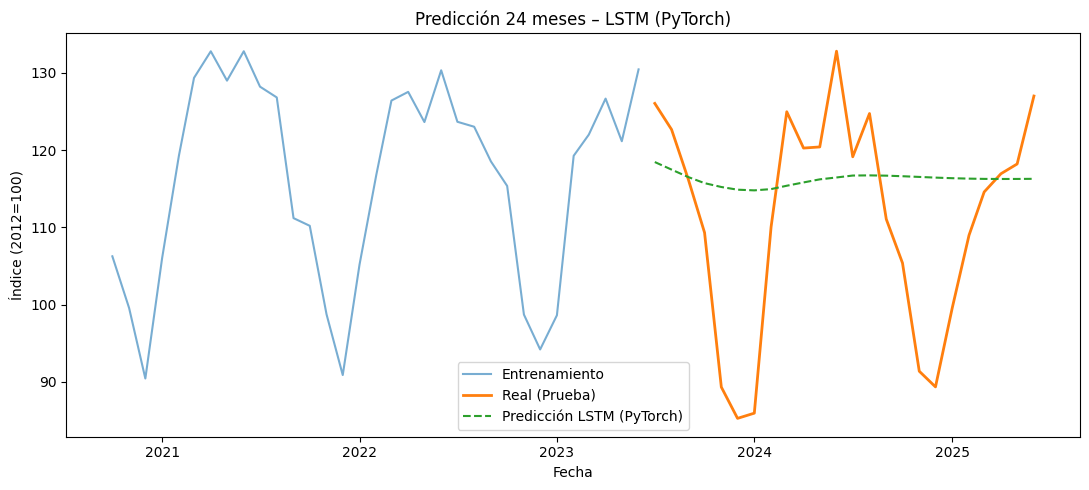

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Asegurar formas compatibles
y_true = test["valor"].values.astype(float).reshape(-1)   # (24,)
y_pred = np.asarray(pred, dtype=float).reshape(-1)        # (24,)

# MSE y RMSE (sin 'squared=False')
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

mae  = mean_absolute_error(y_true, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

plt.figure(figsize=(11,5))
plt.plot(train.index, train["valor"], label="Entrenamiento", alpha=0.6)
plt.plot(test.index,  y_true,           label="Real (Prueba)", linewidth=2)
plt.plot(test.index,  y_pred,           label="Predicción LSTM (PyTorch)", linestyle="--")
plt.title("Predicción 24 meses – LSTM (PyTorch)")
plt.xlabel("Fecha"); plt.ylabel("Índice (2012=100)")
plt.legend(); plt.tight_layout(); plt.show()

## 8) Discusión

El LSTM en PyTorch capturó el patrón estacional de la serie (picos en meses cálidos y caídas en meses fríos),
aunque tiende a suavizar los valores extremos. Los errores (RMSE/MAE) son razonables para un modelo univariado
con ventana de 12 meses. Para mejorar, podría ajustarse el tamaño de la ventana, la profundidad/anchura de la red,
o incorporar una validación temporal con early stopping. También se pueden incluir variables exógenas (ej. clima,
gasto del consumidor) o comparar contra GRU y modelos clásicos estacionales. En general, la predicción sigue la
dinámica esperada y muestra que el enfoque RNN es adecuado para esta serie.